In [ ]:
import requests
import geopy.distance
import csv
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import datetime as dt
import seaborn as sns
import holidays
from sklearn.utils import resample
sns.set(font_scale=0.9)

In [ ]:
city_name = 'Stockholm'
api_url = 'https://opendata-download-metobs.smhi.se/api/version/latest/parameter/'

start_date = dt.date(2021, 1, 1) # first KoDa/GTFS date
end_date = dt.date(2024, 3, 31)
full_dates = pd.DataFrame({'date_dt': pd.date_range(start=start_date, end=end_date, freq='D')})
full_dates['date_dt'] = full_dates['date_dt'].dt.date

city_coordinates = (59.39, 59.28, 18.18, 17.94) # stockholm coords

se_holidays = holidays.SE()

In [ ]:
# total number of days in between start & end
delta = end_date - start_date
print(delta.days)

1185


In [ ]:
def get_available_stations(params, data_mid_lat, data_mid_lon, start_date, end_date):

    union_station = []
    for par in params:
        resp = requests.get(api_url + str(par) + '.json').json()
        data_mid = (data_mid_lat, data_mid_lon)

        stations = []

        for x in resp['station']:
            if dt.date.fromtimestamp(x['from'] / 1000) <= start_date and dt.date.fromtimestamp(x['to'] / 1000) >= end_date:

                station_name = x['name']
                station_mid = (float(x['summary'].split(' ')[1]), float(x['summary'].split(' ')[3]))
                dist = geopy.distance.geodesic(data_mid, station_mid).km
                if dist < 30:  # stations within a radius of 30km of data's midpoint
                    stations.append({'name': station_name, 'dist': dist, 'key': x['key'], 'coord': station_mid})

        stations = sorted(stations, key=lambda d: d['dist'])
        union_station.append(stations)

        print(stations)
    # retrieve all close-ish stations which contain all 3 parameters
    avail_stations = [y for y in [x for x in union_station[0] if x in union_station[1]] if y in union_station[2]]
    return avail_stations

In [ ]:
def retrieve_weather_data(param_string, param_id, station_key, date_regex_ind, content_ind, start_date=start_date, end_date=end_date):
    date_regex = re.compile('^\d{4}-([0][1-9]|1[0-2])-([0][1-9]|[1-2]\d|3[01])$')
    data = requests.get(api_url + str(param_id) + '/station/' + str(station_key) + '/period/corrected-archive/data.csv')

    content_decode = data.content.decode('utf-8')
    content_csv = list(csv.reader(content_decode.splitlines(), delimiter=';'))[26:]
    content_csv = np.array([i for i in content_csv if len(i) == len(content_csv[-1]) and date_regex.match(i[date_regex_ind])])

    df_w = pd.DataFrame()
    df_w['date'] = pd.to_datetime(content_csv[:, date_regex_ind])
    df_w['date_dt'] = df_w['date'].dt.date
    df_w[param_string] = content_csv[:, content_ind]
    # turn to float if numeric
    if pd.to_numeric(df_w[param_string], errors='coerce').notnull().all():
        df_w[param_string] = df_w[param_string].astype(float)

    if param_string == 'prec_mm_hourly' or param_string =='prec_type':
        df_w['hour'] = pd.Series(content_csv[:, 1]).apply(lambda x: int(x[:2])).astype(int)

    if param_string =='prec_type_2':
        df_w['hour'] = pd.Series(content_csv[:, 0]).apply(lambda x: int(x[11:13])).astype(int)

    if param_string == 'temp_min' or param_string =='temp_max' or param_string == 'temp':
        df_w['hour'] = pd.Series(content_csv[:, 1]).apply(lambda x: int(x[:2])).astype(int)
        df_w = df_w[df_w['hour'] <= 6]

    df_w = df_w[(df_w['date_dt'] >= start_date) & (df_w['date_dt'] <= end_date)]

    return df_w


In [ ]:
# find stations close to STH where data is available for the timeframe and parameters
params = [1, 40, 17, 5, 7, 8]
get_available_stations(params, city_coordinates[0], city_coordinates[2], start_date, end_date)

[{'name': 'Stockholm-Observatoriekullen', 'dist': 8.919476651331465, 'key': '98210', 'coord': (59.3417, 18.0549)}, {'name': 'Stockholm-Observatoriekullen A', 'dist': 8.919476651331465, 'key': '98230', 'coord': (59.3417, 18.0549)}, {'name': 'Stockholm-Bromma Flygplats', 'dist': 13.61691079259537, 'key': '97200', 'coord': (59.3537, 17.9513)}, {'name': 'Tullinge A', 'dist': 28.16402055744708, 'key': '97100', 'coord': (59.1785, 17.9093)}, {'name': 'Stockholm-Arlanda Flygplats', 'dist': 29.318302741880295, 'key': '97400', 'coord': (59.6269, 17.9545)}]
[{'name': 'Stockholm-Observatoriekullen', 'dist': 8.919476651331465, 'key': '98210', 'coord': (59.3417, 18.0549)}, {'name': 'Vallentuna', 'dist': 15.41464997576501, 'key': '98310', 'coord': (59.5185, 18.0792)}, {'name': 'Stormyra', 'dist': 22.519015942465128, 'key': '98140', 'coord': (59.2024, 18.3272)}, {'name': 'Norsborg 2', 'dist': 26.74116585400929, 'key': '97160', 'coord': (59.2518, 17.796)}]
[{'name': 'Stockholm-Observatoriekullen', 'dis

[{'name': 'Stockholm-Observatoriekullen',
  'dist': 8.919476651331465,
  'key': '98210',
  'coord': (59.3417, 18.0549)}]

## Temperature (at 6:00)

In [ ]:
df_temp = retrieve_weather_data('temp', 1, 98210, 0, 2)
df_temp

,date,date_dt,temp,hour
201492,2021-01-01,2021-01-01,2.9,6
201494,2021-01-02,2021-01-02,2.3,6
201496,2021-01-03,2021-01-03,0.4,6
201498,2021-01-04,2021-01-04,0.3,6
201500,2021-01-05,2021-01-05,0.2,6
...,...,...,...,...
203854,2024-03-27,2024-03-27,3.1,6
203856,2024-03-28,2024-03-28,4.5,6
203858,2024-03-29,2024-03-29,5.9,6
203860,2024-03-30,2024-03-30,5.6,6


## Ground Condition (at 6:00)

In [ ]:
df_ground_condition = retrieve_weather_data('ground_code', 40, 98210, 0, 2)
df_ground_condition

,date,date_dt,ground_code
12899,2021-01-01,2021-01-01,0.0
12900,2021-01-02,2021-01-02,0.0
12901,2021-01-03,2021-01-03,0.0
12902,2021-01-04,2021-01-04,11.0
12903,2021-01-05,2021-01-05,0.0
...,...,...,...
14080,2024-03-27,2024-03-27,0.0
14081,2024-03-28,2024-03-28,0.0
14082,2024-03-29,2024-03-29,0.0
14083,2024-03-30,2024-03-30,0.0


In [ ]:
df_ground_condition.ground_code.unique()

array([ 0., 11., 17., 12.])

SMHI ground condition codes:

https://opendata.smhi.se/metobs/codes
- 0	Torr (utan sprickor eller nämnvärd mängd stoft eller lös sand)
- 11	Delvis eller helt täckt av packad eller våt snö – till mindre än hälften
- 12	Delvis eller helt täckt av packad eller våt snö – till minst hälften men ej helt
- 17	Delvis eller helt täckt av lös och torr snö – helt och i ett jämnt lager

engl:
- 11 Partially or completely covered by packed or wet snow – less than half
- 12 Partially or completely covered by packed or wet snow – at least half but not completely
- 17 Partially or completely covered by loose and dry snow – completely and in an even layer


*COMMENT: could group 11 and 12 into one category*

In [ ]:
ground_codes = {
    0. : "dry",
    11.: "partial_snow_packed_wet_lt_half",
    12.: "partial_snow_packed_wet_el_half",
    17. : "complete_snow_loose_dry",
}

df_ground_condition['ground_expl'] = df_ground_condition['ground_code'].map(ground_codes)
df_ground_condition

,date,date_dt,ground_code,ground_expl
12899,2021-01-01,2021-01-01,0.0,dry
12900,2021-01-02,2021-01-02,0.0,dry
12901,2021-01-03,2021-01-03,0.0,dry
12902,2021-01-04,2021-01-04,11.0,partial_snow_packed_wet_lt_half
12903,2021-01-05,2021-01-05,0.0,dry
...,...,...,...,...
14080,2024-03-27,2024-03-27,0.0,dry
14081,2024-03-28,2024-03-28,0.0,dry
14082,2024-03-29,2024-03-29,0.0,dry
14083,2024-03-30,2024-03-30,0.0,dry


## Precipitation

Param 5

https://www.smhi.se/data/hitta-data-for-en-plats/ladda-ner-vaderobservationer/precipitation24HourSum/97100
- sum over last 24h, measured at 6 am


Param 7

https://www.smhi.se/data/hitta-data-for-en-plats/ladda-ner-vaderobservationer/precipitationHourlySum/97100
- hourly amount

In [ ]:
df_precip_total_daily = retrieve_weather_data('prec_mm_total_24h', 5, 98210, 2, 3)
df_precip_total_daily

,date,date_dt,prec_mm_total_24h
58789,2021-01-01,2021-01-01,10.3
58790,2021-01-02,2021-01-02,1.6
58791,2021-01-03,2021-01-03,0.2
58792,2021-01-04,2021-01-04,0.0
58793,2021-01-05,2021-01-05,0.0
...,...,...,...
59970,2024-03-27,2024-03-27,0.0
59971,2024-03-28,2024-03-28,4.6
59972,2024-03-29,2024-03-29,0.0
59973,2024-03-30,2024-03-30,0.0


In [ ]:
# this dataset doesn't exist for Observatoriekullen outside of 2024, thus used Tullinge A data
df_rain_hourly = retrieve_weather_data('prec_mm_hourly', 7, 97100, 0, 2)
df_rain_hourly
# aggregate over first 6 hours
df_precip_total_6h = df_rain_hourly[df_rain_hourly.hour <= 6].groupby('date_dt').prec_mm_hourly.sum().reset_index().rename(columns={'prec_mm_hourly':'prec_mm_6h'})
# for days where no data, assume prec 0
# check if all dates between start_date, end_date are givne in rows, if not -> make new row with date and put prec_mm_6h to 0
df_precip_total_6h = full_dates.merge(df_precip_total_6h, on='date_dt', how='left')
df_precip_total_6h['prec_mm_6h'] = df_precip_total_6h['prec_mm_6h'].fillna(0)
df_precip_total_6h

,date_dt,prec_mm_6h
0,2021-01-01,0.0
1,2021-01-02,4.2
2,2021-01-03,0.0
3,2021-01-04,0.0
4,2021-01-05,0.0
...,...,...
1181,2024-03-27,0.0
1182,2024-03-28,0.0
1183,2024-03-29,0.1
1184,2024-03-30,0.0


## Precipitation type

In [ ]:
df_prec_type = retrieve_weather_data('prec_type', 17, 98210, 0, 2)
# get only values from 6:00
df_prec_type = df_prec_type[df_prec_type.hour == 6]
df_prec_type

,date,date_dt,prec_type,hour
303,2021-01-02,2021-01-02,Regn,6
306,2021-01-04,2021-01-04,Snöfall,6
309,2021-01-07,2021-01-07,Snöfall,6
314,2021-01-12,2021-01-12,Snöblandat regn,6
317,2021-01-14,2021-01-14,Snöfall,6
...,...,...,...,...
1030,2024-03-21,2024-03-21,Regnskurar,6
1031,2024-03-22,2024-03-22,Regn,6
1032,2024-03-23,2024-03-23,Regnskurar,6
1033,2024-03-24,2024-03-24,Regn,6


In [ ]:
df_prec_type.date.nunique()

365

number of observations = number of days, so there is only one type per day (at 6am)

In [ ]:
# compare whether missing days in prec_type_df are the same as where precip_mm == 0
# i.e. the dates in df_prec_dt should correspond to those in df_precip_total_6h where prec_mm_6h is not 0. please check that this is the case and show the rows where it isnt.
# conversely, also show that the dates that do not exist in df_prec_dt are in df_precip_total_6h, and there have 0 precip.
display(df_precip_total_6h[df_precip_total_6h.prec_mm_6h == 0].date_dt.isin(df_prec_type.date_dt).value_counts())
display(df_precip_total_6h[df_precip_total_6h.prec_mm_6h != 0].date_dt.isin(df_prec_type.date_dt).value_counts())

,count
date_dt,
False,759
True,154


,count
date_dt,
True,211
False,62


too many days of missing data:/

## Snow depth

In [ ]:
df_snow_depth = retrieve_weather_data('snow_mm', 8, 98210, 0, 2)
df_snow_depth['snow_mm'] = df_snow_depth['snow_mm']*100
df_snow_depth = df_snow_depth.rename(columns={'snow_mm': 'snow_cm'})

# calc snow depth diff to previous day
df_snow_depth = df_snow_depth.sort_values(by='date_dt')
df_snow_depth['snow_cm_diff'] = df_snow_depth['snow_cm'].diff()
df_snow_depth['snow_cm_diff'].iloc[0] = df_snow_depth['snow_cm'].iloc[0]

# set negative values to 0
df_snow_depth['snow_cm_diff'] = df_snow_depth['snow_cm_diff'].apply(lambda x: 0 if x < 0 else x)
df_snow_depth

<ipython-input-16-7d8fc18c5611>:8: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  df_snow_depth['snow_cm_diff'].iloc[0] = df_snow_depth['snow_cm'].iloc[0]
<ipython-input-16-7d8fc18c5611>:8: SettingWithCopyWarning: 
A value is trying to be set

,date,date_dt,snow_cm,snow_cm_diff
8171,2021-01-01,2021-01-01,0.0,0.0
8172,2021-01-02,2021-01-02,0.0,0.0
8173,2021-01-03,2021-01-03,0.0,0.0
8174,2021-01-04,2021-01-04,0.0,0.0
8175,2021-01-05,2021-01-05,0.0,0.0
...,...,...,...,...
9352,2024-03-27,2024-03-27,0.0,0.0
9353,2024-03-28,2024-03-28,0.0,0.0
9354,2024-03-29,2024-03-29,0.0,0.0
9355,2024-03-30,2024-03-30,0.0,0.0


## Combine all into one df

In [ ]:
# merge all weather dfs into one df, match on date

# for df in [df_temp, df_ground_condition, df_precip_total_daily, df_snow_depth]:
#     df.drop(columns=['date'], inplace=True)

df_weather = df_temp.copy()
df_weather = df_weather.merge(df_ground_condition, on='date_dt', how='outer')
df_weather = df_weather.merge(df_precip_total_daily, on='date_dt', how='outer')
df_weather = df_weather.merge(df_precip_total_6h, on='date_dt', how='outer')
df_weather = df_weather.merge(df_snow_depth, on='date_dt', how='outer')

df_weather = df_weather.sort_values('date_dt').reset_index(drop=True)

In [ ]:
df_weather = df_weather.rename(columns={'snow_cm': 'snow_depth_cm', 'snow_cm_diff': 'snow_depth_cm_accumulated'})
df_weather['ground_code'] = df_weather['ground_code'].astype(int)
df_weather = df_weather.drop(columns='hour')
df_weather

,date_dt,temp,ground_code,ground_expl,prec_mm_total_24h,prec_mm_6h,snow_depth_cm,snow_depth_cm_accumulated
0,2021-01-01,2.9,0,dry,10.3,0.0,0.0,0.0
1,2021-01-02,2.3,0,dry,1.6,4.2,0.0,0.0
2,2021-01-03,0.4,0,dry,0.2,0.0,0.0,0.0
3,2021-01-04,0.3,11,partial_snow_packed_wet_lt_half,0.0,0.0,0.0,0.0
4,2021-01-05,0.2,0,dry,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...
1181,2024-03-27,3.1,0,dry,0.0,0.0,0.0,0.0
1182,2024-03-28,4.5,0,dry,4.6,0.0,0.0,0.0
1183,2024-03-29,5.9,0,dry,0.0,0.1,0.0,0.0
1184,2024-03-30,5.6,0,dry,0.0,0.0,0.0,0.0


In [ ]:
# df_weather.to_csv('weather_data_all_cols_full_date_range.csv')

In [ ]:
df_weather['date'] = pd.to_datetime(df_weather['date_dt'])
df_weather['month'] = df_weather['date'].dt.month
df_weather['day'] = df_weather['date'].dt.day
df_weather['year'] = df_weather['date'].dt.year
df_weather['dow'] = df_weather['date'].dt.dayofweek
df_weather['dow_name'] = df_weather['date'].dt.day_name()

## Filter df to only include winter months, weekdays, and holidays

In [ ]:
df_weather_filt = df_weather[(df_weather['month'] <= 3) | (df_weather['month'] >= 11)]
df_weather_filt = df_weather_filt[df_weather_filt['date'].dt.dayofweek < 5]
df_weather_filt['holiday'] = df_weather_filt['date'].apply(lambda x: x in se_holidays)
display(df_weather_filt[df_weather_filt['holiday'] == True]['date'].apply(lambda x: se_holidays.get(x)))
df_weather_filt = df_weather_filt[df_weather_filt['holiday'] == False]
print(df_weather_filt.shape)

,date
0,New Year's Day
5,Epiphany
357,Christmas Eve
364,New Year's Eve
370,Epiphany
724,Second Day of Christmas
735,Epiphany
1088,Christmas Day
1089,Second Day of Christmas
1095,New Year's Day


(379, 15)


## Split into snow days and control days, further sample control days to have similar distirbution as snow days

In [ ]:
df_snowdays = df_weather_filt[df_weather_filt['snow_depth_cm_accumulated']>0]
df_snowdays

,date_dt,temp,ground_code,ground_expl,prec_mm_total_24h,prec_mm_6h,snow_depth_cm,snow_depth_cm_accumulated,date,month,day,year,dow,dow_name,holiday
6,2021-01-07,0.0,17,complete_snow_loose_dry,0.7,0.4,1.0,1.0,2021-01-07,1,7,2021,3,Thursday,False
10,2021-01-11,-3.0,17,complete_snow_loose_dry,26.6,0.0,4.0,4.0,2021-01-11,1,11,2021,0,Monday,False
12,2021-01-13,-2.0,17,complete_snow_loose_dry,6.1,0.0,2.0,1.0,2021-01-13,1,13,2021,2,Wednesday,False
13,2021-01-14,-2.7,17,complete_snow_loose_dry,1.0,1.2,12.0,10.0,2021-01-14,1,14,2021,3,Thursday,False
14,2021-01-15,-9.9,17,complete_snow_loose_dry,0.5,0.0,14.0,2.0,2021-01-15,1,15,2021,4,Friday,False
25,2021-01-26,-3.1,17,complete_snow_loose_dry,0.0,0.0,6.0,6.0,2021-01-26,1,26,2021,1,Tuesday,False
28,2021-01-29,-4.0,17,complete_snow_loose_dry,0.3,0.0,17.0,12.0,2021-01-29,1,29,2021,4,Friday,False
33,2021-02-03,-6.0,17,complete_snow_loose_dry,0.3,0.0,24.0,12.0,2021-02-03,2,3,2021,2,Wednesday,False
41,2021-02-11,-11.8,17,complete_snow_loose_dry,0.1,0.1,16.0,2.0,2021-02-11,2,11,2021,3,Thursday,False
42,2021-02-12,-10.7,17,complete_snow_loose_dry,0.0,0.0,17.0,1.0,2021-02-12,2,12,2021,4,Friday,False


In [ ]:
df_controldays = df_weather_filt[df_weather_filt['snow_depth_cm_accumulated']==0]

# sample control days to have similar distribution as snowdays
snow_dist = df_snowdays.groupby(['dow', 'month', 'year']).size().reset_index(name='count')
control_samples = []

for _, row in snow_dist.iterrows():
    dow, month, year, n_samples = row['dow'], row['month'], row['year'], row['count']
    subset = df_controldays[(df_controldays['dow'] == dow) &
                         (df_controldays['month'] == month) &
                         (df_controldays['year'] == year)]

    if not subset.empty:
        n = min(n_samples, subset.shape[0])  # avoid oversampling
        sampled = resample(subset, replace=False, n_samples=n, random_state=42)
        control_samples.append(sampled)

df_control_dates = pd.concat(control_samples).reset_index(drop=True)
df_control_dates = df_control_dates.sort_values(by='date').reset_index(drop=True)
df_control_dates

,date_dt,temp,ground_code,ground_expl,prec_mm_total_24h,prec_mm_6h,snow_depth_cm,snow_depth_cm_accumulated,date,month,day,year,dow,dow_name,holiday
0,2021-01-04,0.3,11,partial_snow_packed_wet_lt_half,0.0,0.0,0.0,0.0,2021-01-04,1,4,2021,0,Monday,False
1,2021-01-05,0.2,0,dry,0.0,0.0,0.0,0.0,2021-01-05,1,5,2021,1,Tuesday,False
2,2021-01-08,0.5,11,partial_snow_packed_wet_lt_half,0.9,0.0,0.0,0.0,2021-01-08,1,8,2021,4,Friday,False
3,2021-01-21,4.1,11,partial_snow_packed_wet_lt_half,0.5,2.0,0.0,0.0,2021-01-21,1,21,2021,3,Thursday,False
4,2021-01-22,4.1,11,partial_snow_packed_wet_lt_half,4.8,0.0,0.0,0.0,2021-01-22,1,22,2021,4,Friday,False
5,2021-01-27,-3.7,17,complete_snow_loose_dry,0.0,0.0,5.0,0.0,2021-01-27,1,27,2021,2,Wednesday,False
6,2021-01-28,-5.6,17,complete_snow_loose_dry,10.9,0.0,5.0,0.0,2021-01-28,1,28,2021,3,Thursday,False
7,2021-02-04,-9.1,17,complete_snow_loose_dry,0.1,0.0,23.0,0.0,2021-02-04,2,4,2021,3,Thursday,False
8,2021-02-05,-8.9,17,complete_snow_loose_dry,0.4,0.0,18.0,0.0,2021-02-05,2,5,2021,4,Friday,False
9,2021-02-10,-11.7,17,complete_snow_loose_dry,1.1,0.0,14.0,0.0,2021-02-10,2,10,2021,2,Wednesday,False


In [ ]:
print('Number of snow days:', df_snowdays.shape[0])
print('Number of control days:', df_control_dates.shape[0])

Number of snow days: 55
Number of control days: 55


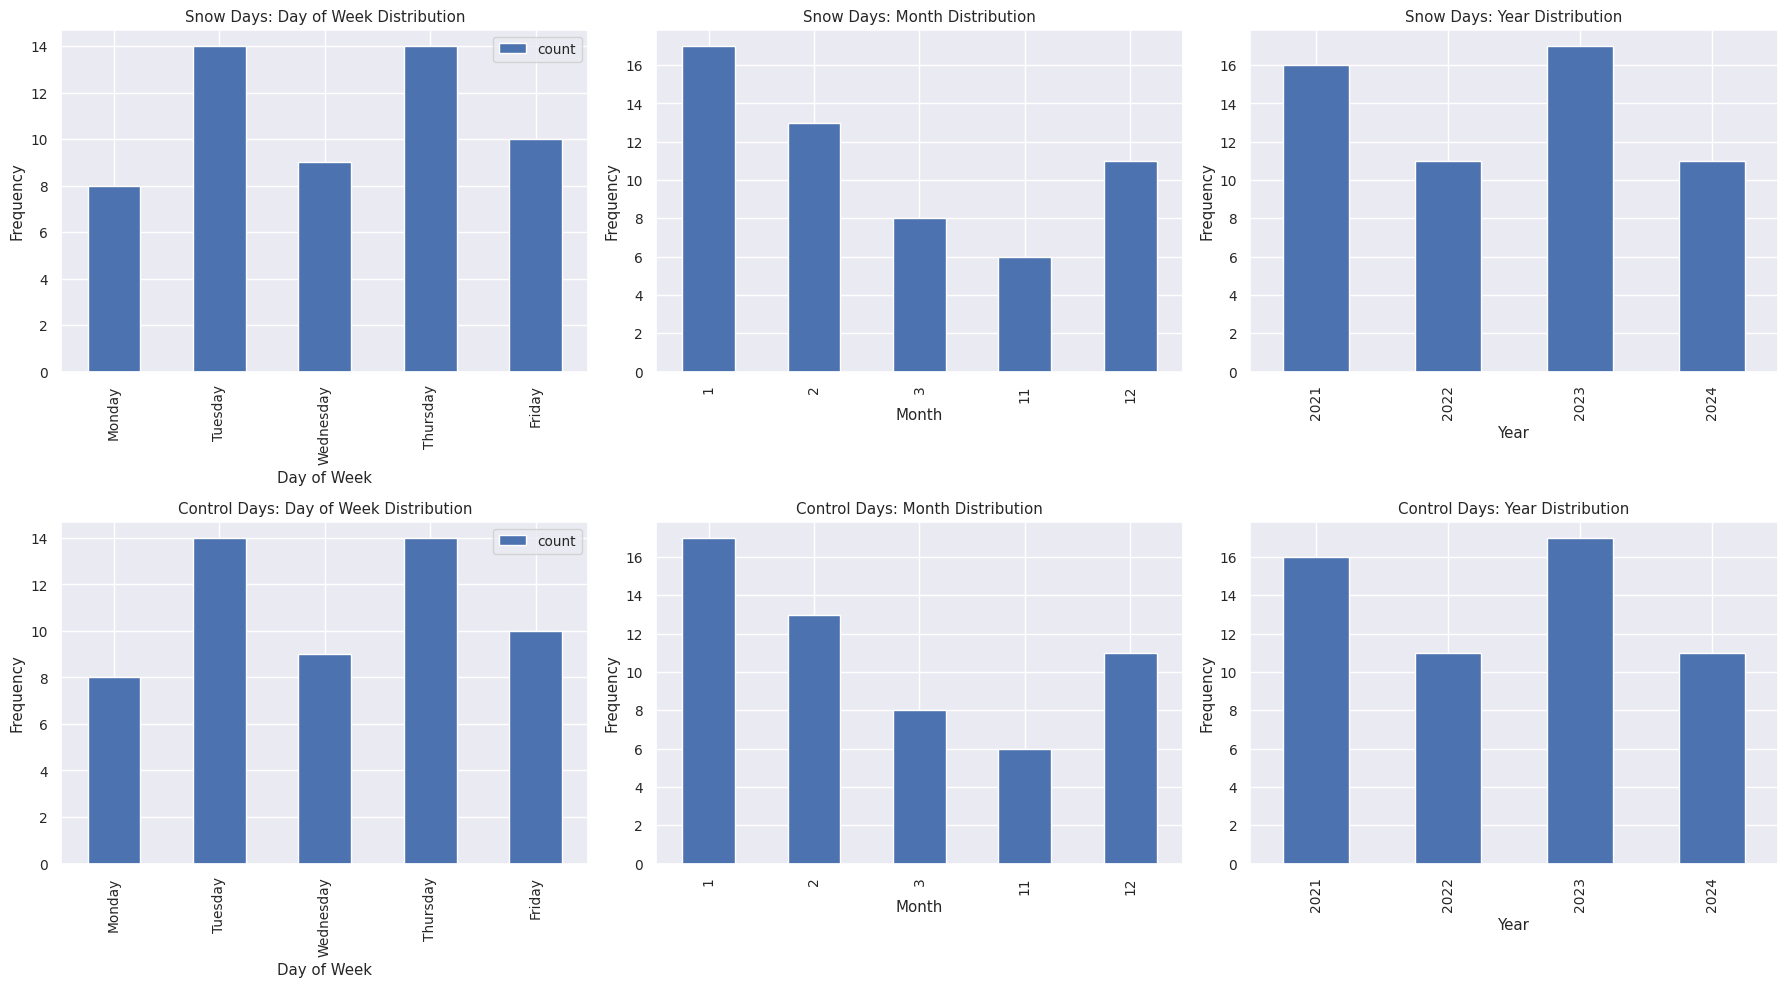

In [ ]:
fig, axes = plt.subplots(2, 3, figsize=(18, 10))

weekday_order = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday"]

df_snowdays[['dow', 'dow_name']].value_counts().sort_index().reset_index()\
    .plot(kind='bar', x='dow_name', y='count', xlabel='Day of Week', ylabel='Frequency',
          title='Snow Days: Day of Week Distribution', ax=axes[0, 0])

df_control_dates[['dow', 'dow_name']].value_counts().sort_index().reset_index()\
    .plot(kind='bar', x='dow_name', y='count', xlabel='Day of Week', ylabel='Frequency',
          title='Control Days: Day of Week Distribution', ax=axes[1, 0])

df_snowdays['month'].value_counts().sort_index().plot(kind='bar', xlabel='Month', ylabel='Frequency',
    title='Snow Days: Month Distribution', ax=axes[0, 1])

df_control_dates['month'].value_counts().sort_index().plot(kind='bar', xlabel='Month', ylabel='Frequency',
    title='Control Days: Month Distribution', ax=axes[1, 1])

df_snowdays['year'].value_counts().sort_index().plot(kind='bar', xlabel='Year', ylabel='Frequency',
    title='Snow Days: Year Distribution', ax=axes[0, 2])

df_control_dates['year'].value_counts().sort_index().plot(kind='bar', xlabel='Year', ylabel='Frequency',
    title='Control Days: Year Distribution', ax=axes[1, 2])

plt.tight_layout()
plt.show()

<ipython-input-31-1e82f17177f9>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_snowdays['type'] = 'Snow Days'


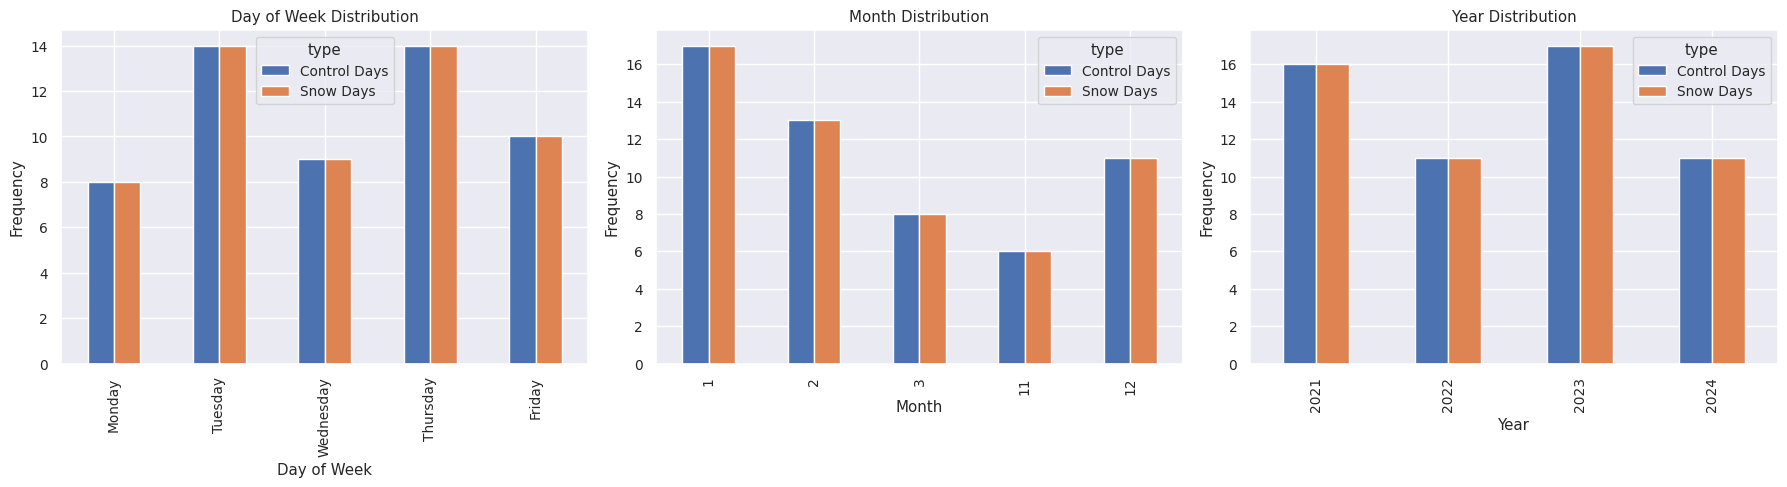

In [ ]:
# plot everythign in the same plot
df_snowdays['type'] = 'Snow Days'
df_control_dates['type'] = 'Control Days'
combined = pd.concat([df_snowdays, df_control_dates], ignore_index=True)

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

dow_counts = combined.groupby(['dow_name', 'type']).size().unstack().reindex(weekday_order)
dow_counts.plot(kind='bar', ax=axes[0])
axes[0].set_title('Day of Week Distribution')
axes[0].set_xlabel('Day of Week')
axes[0].set_ylabel('Frequency')

month_counts = combined.groupby(['month', 'type']).size().unstack()
month_counts.plot(kind='bar', ax=axes[1])
axes[1].set_title('Month Distribution')
axes[1].set_xlabel('Month')
axes[1].set_ylabel('Frequency')

year_counts = combined.groupby(['year', 'type']).size().unstack()
year_counts.plot(kind='bar', ax=axes[2])
axes[2].set_title('Year Distribution')
axes[2].set_xlabel('Year')
axes[2].set_ylabel('Frequency')

plt.tight_layout()
plt.show()


In [ ]:
sns.set(font_scale=0.9)

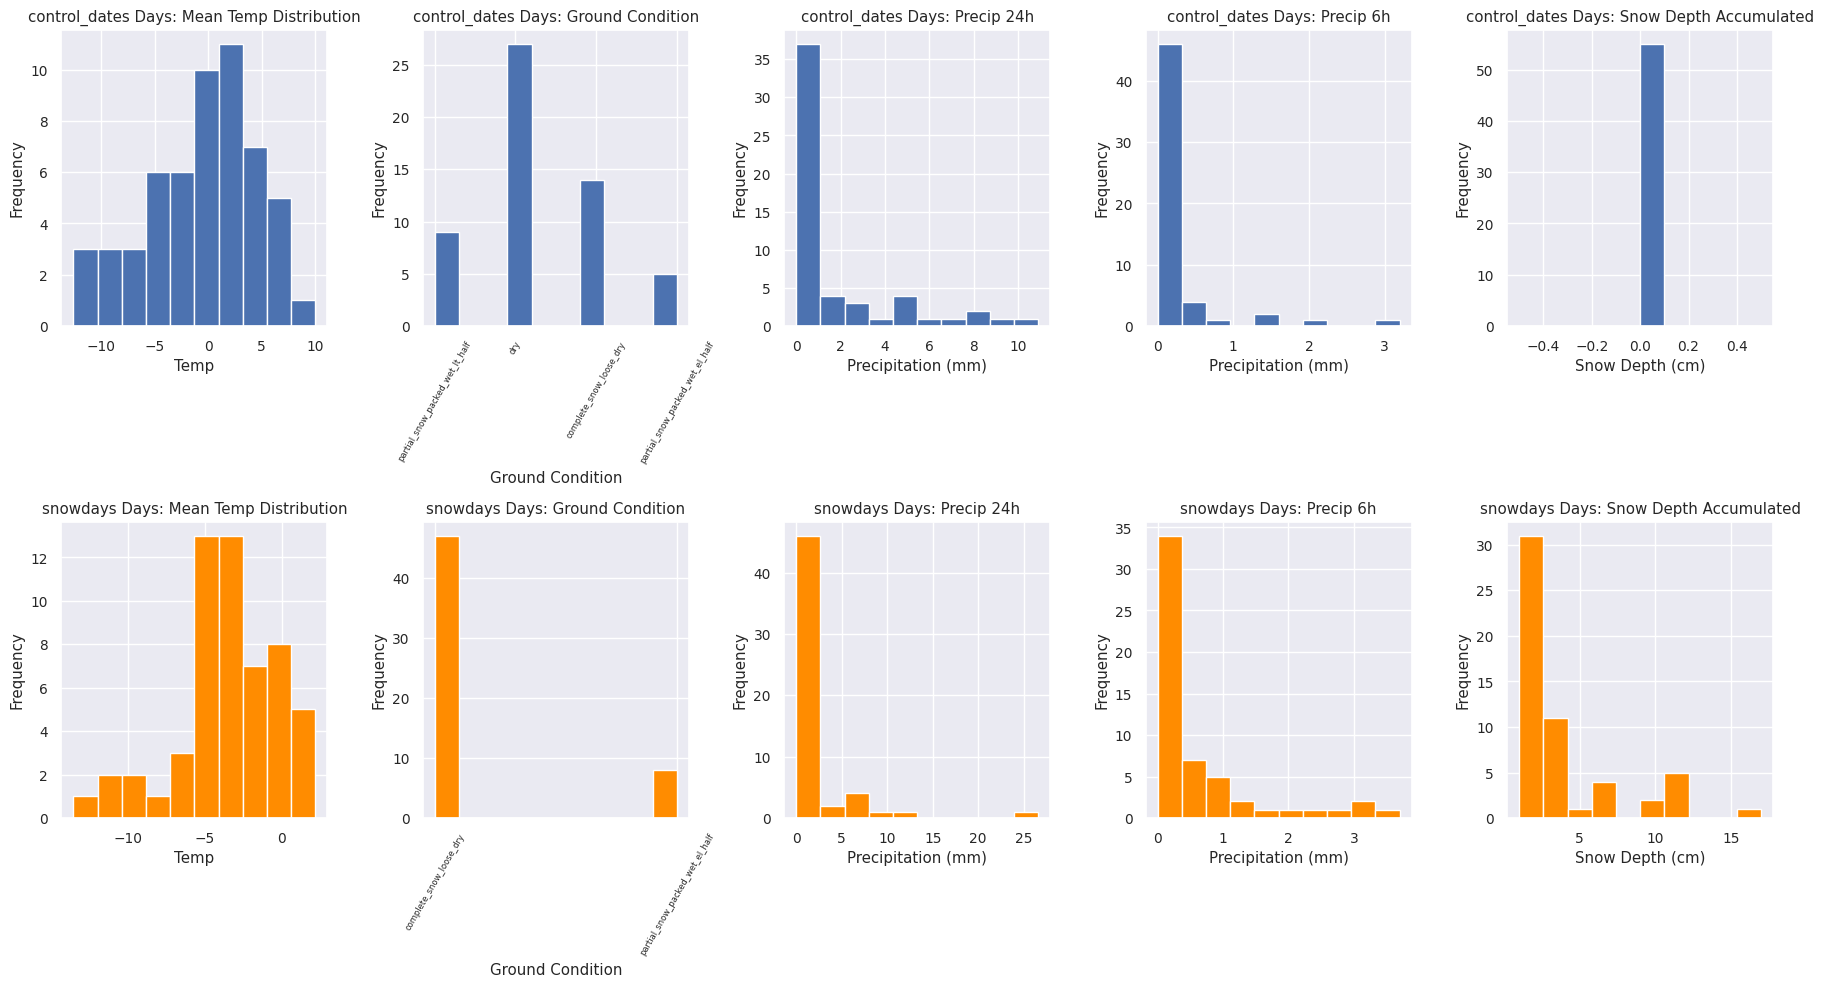

In [ ]:
fig, axes = plt.subplots(2, 5, figsize=(18, 10))

data_dict = {
    'temp': ('Mean Temp Distribution', 'Temp', 'Frequency'),
    'ground_expl': ('Ground Condition', 'Ground Condition', 'Frequency'),
    'prec_mm_total_24h': ('Precip 24h', 'Precipitation (mm)', 'Frequency'),
    'prec_mm_6h': ('Precip 6h', 'Precipitation (mm)', 'Frequency'),
    'snow_depth_cm_accumulated': ('Snow Depth Accumulated', 'Snow Depth (cm)', 'Frequency')
}

for i, (df, label) in enumerate([('control_dates', df_control_dates), ('snowdays', df_snowdays)]):
    for j, (col, (title, xlabel, ylabel)) in enumerate(data_dict.items()):
        ax = axes[i, j]
        eval(f'df_{df}["{col}"]').hist(bins=10, ax=ax, color=('darkorange' if i == 1 else None))
        # df[col].hist(bins=10, ax=ax, color=)
        ax.set_title(f'{df} Days: {title}')
        ax.set_xlabel(xlabel)
        ax.set_ylabel(ylabel)

axes[0, 1].tick_params(axis='x', rotation=60, labelsize=6)
axes[1, 1].tick_params(axis='x', rotation=60, labelsize=6)

plt.tight_layout()
plt.show()

In [ ]:
# df_snowdays.to_csv('snowdays_DEPTHBASED.csv')
# df_control_dates.to_csv('controldays_DEPTHBASED.csv')